In [ ]:
"""
To practice extracting the axon automatically using the 
newly created filtering rules

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [12]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru

import preprocessing_vp2 as pre

# -- For the axon classification --

import neuron_searching as ns

# Importing Neuron

In [5]:
neuron_obj_file = "classic_double_neuron_1"

In [6]:
curr_neuron_obj = nru.decompress_neuron(neuron_obj_file,neuron_obj_file)

Decompressing Neuron in minimal output mode...please wait


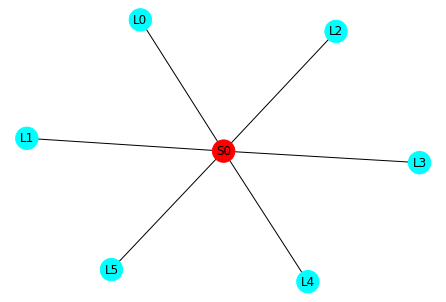

In [7]:
nviz.plot_soma_limb_concept_network(curr_neuron_obj)

In [8]:
nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# 0) Check that only one soma

In [9]:
soma_names = curr_neuron_obj.get_soma_node_names()
if len(soma_names)>1:
    raise Exception(f"More than 1 soma: {soma_names}")

soma_name = soma_names[0]

# 1) Classify All Axon Segments

In [16]:
axon_like_limb_branch_dict = ns.axon_width_like_segments(curr_neuron_obj,
                                                        include_ais=True)



# nviz.visualize_neuron(curr_neuron_obj,
#                       visualize_type=["mesh"],
#                      limb_branch_dict=axon_like_limb_branch_dict,
#                      mesh_color="red",
#                       mesh_color_alpha=1,
#                      mesh_whole_neuron=True)

current_functions_list = ["axon_segment"]
final_axon_like_classification = ns.query_neuron(curr_neuron_obj,
                                        
                                   query="axon_segment==True",
                                   function_kwargs=dict(limb_branch_dict =axon_like_limb_branch_dict,
                                                        downstream_face_threshold=3000,
                                                        width_match_threshold=50,
                                                       print_flag=False),
                                   functions_list=current_functions_list)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=final_axon_like_classification,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)

current_query = (n_spines < 4 and (median_mesh_center < 600) and skeleton_distance_branch <= 15000) or (skeleton_distance_branch > 15000 and (median_mesh_center < 600) and spines_per_skeletal_length < 0.00023)
functions_list = [<function width at 0x7f1c20d2d840>, <function median_mesh_center at 0x7f1c20d2d2f0>, <function n_spines at 0x7f1c20d2d8c8>, <function n_faces_branch at 0x7f1c20d2d158>, <function skeleton_distance_branch at 0x7f1c20d2d950>, <function spines_per_skeletal_length at 0x7f1c20d2d620>, <function no_spine_median_mesh_center at 0x7f1c20d2d400>]
functions_list = [<function axon_segment at 0x7f1c20d1c7b8>]

 Working on visualization type: mesh


In [29]:
# want to label all branches as "axon_like"
current_label = "axon-like"

nru.add_branch_label(curr_neuron_obj,
                    limb_branch_dict=final_axon_like_classification,
                    labels=current_label)


In [34]:
current_functions_list = ["matching_label"]

recovered_axon_branches = ns.query_neuron(curr_neuron_obj,
                query="matching_label==True",
                function_kwargs=dict(labels =["axon-like"]),
                functions_list=current_functions_list
               )

recovered_axon_branches

functions_list = [<function matching_label at 0x7f1c21efa730>]


{'L0': array([ 1,  3,  5,  7,  8, 16, 18, 20, 21, 38, 45]),
 'L1': array([ 3,  4,  9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]),
 'L2': array([ 4,  6,  8,  9, 11, 12, 13, 14, 15, 16, 23]),
 'L4': array([0]),
 'L5': array([3])}

# 2) Filter Limbs By Starting Angle

In [50]:
axon_soma_angle_threshold = 70

soma_center = curr_neuron_obj["S0"].mesh_center

possible_axon_limbs_dict = ns.query_neuron(curr_neuron_obj,
                query=f"soma_starting_angle>{axon_soma_angle_threshold}",
               functions_list=[ns.soma_starting_angle],
               function_kwargs=dict(soma_center=soma_center,
                                   verbose=True))

possible_axon_limbs = list(possible_axon_limbs_dict.keys())
possible_axon_limbs = [nru.get_limb_int_name(k) for k in possible_axon_limbs]
possible_axon_limbs

functions_list = [<function soma_starting_angle at 0x7f1c20d2d158>]
Limb L0 soma angle: 2.56 
Limb L1 soma angle: 106.07 
Limb L2 soma angle: 98.8 
Limb L3 soma angle: 122.76 
Limb L4 soma angle: 134.4 
Limb L5 soma angle: 106.31 


[1, 2, 3, 4, 5]

# 3) Get all of the Viable Candidates

In [51]:
#1) Find all branches that are less than [ais_threshold] distance
#away from the soma

ais_threshold = 20000
close_limb_branch_dict = ns.query_neuron(curr_neuron_obj,
                                        functions_list=[ns.skeletal_distance_from_soma],
                                        query=f"skeletal_distance_from_soma<{ais_threshold}",
                                        function_kwargs=dict(limbs_to_process=possible_axon_limbs),
                                         #return_dataframe=False


                                        )
outside_bubble_limb_branch_dict = ns.query_neuron(curr_neuron_obj,
                                        functions_list=[ns.skeletal_distance_from_soma],
                                        query=f"skeletal_distance_from_soma>={ais_threshold}",
                                        function_kwargs=dict(limbs_to_process=possible_axon_limbs),
                                         #return_dataframe=False


                                        )

colors_dict_returned = nviz.visualize_neuron(curr_neuron_obj,
                      limb_branch_dict=close_limb_branch_dict,
                     mesh_color="red",
                     mesh_color_alpha=1,
                     mesh_whole_neuron=True,
                     return_color_dict=True)

functions_list = [<function skeletal_distance_from_soma at 0x7f1c21ede268>]
functions_list = [<function skeletal_distance_from_soma at 0x7f1c21ede268>]

 Working on visualization type: mesh

 Working on visualization type: skeleton


In [53]:
# 2) Delete the nodes from the branch graph and then group into connected ocmponents
# into candidates

"""
Pseudocode:
1) Get the limbs touching the soma of inteterst


"""

import networkx_utils as xu
import networkx as nx
import matplotlib_utils as mu

limbs_to_check = [nru.get_limb_string_name(k) for k in possible_axon_limbs]

sub_limb_color_dict = dict()
total_sub_limbs = dict() #will map the limbs to the connected components

verbose = True

for limb_idx in limbs_to_check:
    print(f"\nWorking on Limb {limb_idx}")
    
    #initializing the candidate list and the color dictionary for visualization
    total_sub_limbs[limb_idx] = []
    sub_limb_color_dict[limb_idx] = dict()
    
    
    
    curr_limb = curr_neuron_obj[limb_idx]
    
    if limb_idx in close_limb_branch_dict.keys():
        nodes_to_eliminate = close_limb_branch_dict[limb_idx]
    else:
        nodes_to_eliminate = []
    
    #the nodes that were eliminated we need to show deleted colors
    for n in nodes_to_eliminate:
        sub_limb_color_dict[limb_idx][n] = mu.color_to_rgba("black", alpha=1)
    
    if verbose:
        print(f"nodes_to_eliminate = {nodes_to_eliminate}")
        
    curr_filt_network = nx.Graph(curr_limb.concept_network_directional)
    curr_filt_network.remove_nodes_from(nodes_to_eliminate)
    
    if len(curr_filt_network) == 0:
        if verbose:
            print("The filtered network is empty so just leaving the candidates as empty lists")
        continue
        
    curr_limb_conn_comp = list(nx.connected_components(curr_filt_network))
    

    total_sub_limbs[limb_idx] = [list(k) for k in curr_limb_conn_comp]
    
    colors_to_use = mu.generate_unique_random_color_list(n_colors=len(curr_limb_conn_comp),colors_to_omit=["black","midnightblue"])
    for j,(c_comp,curr_random_color) in enumerate(zip(curr_limb_conn_comp,colors_to_use)):

        for n in c_comp:
            sub_limb_color_dict[limb_idx][n] = curr_random_color
            
            
nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict="all",
                     mesh_color=sub_limb_color_dict,
                     mesh_fill_color="green")


Working on Limb L1
nodes_to_eliminate = []

Working on Limb L2
nodes_to_eliminate = [20 22]

Working on Limb L3
nodes_to_eliminate = [3]

Working on Limb L4
nodes_to_eliminate = [0]
The filtered network is empty so just leaving the candidates as empty lists

Working on Limb L5
nodes_to_eliminate = [0]

 Working on visualization type: mesh


In [55]:
"""
3) Adding back all endpoints that were eliminated in step 2: Process is below

For each limb

0) Get all of the endpoint nodes in the whole directed concept network
- remove the starting node from the list
1) Find the shortest path from every endpoint to the starting node
2) Concatenate shortest paths into dictionary mapping node to number of
occurances in the shortest paths
3) Find all of the endpoints that were eliminated with the restriction
4) Filter those endpoint paths for nodes that only have an 
occurance of one for the lookup dictionary
5) Add all deleted endpoint filtered shortest paths as candidates

How to handle corner cases:
1) If only starting node that got deleted
--> just add that as a candidate
2) If all of network got deleted, current way will work

"""

removed_candidates = dict()

for limb_idx in limbs_to_check:
    if verbose:
        print(f"\n----Working on Limb {limb_idx}-----")
        
    curr_limb = curr_neuron_obj[limb_idx]    
    
    removed_candidates[limb_idx] = []
    
    if limb_idx in close_limb_branch_dict.keys():
        nodes_to_eliminate = close_limb_branch_dict[limb_idx]
    else:
        nodes_to_eliminate = []
        if verbose:
            print("No nodes were eliminated so don't need to add back any candidates")
        continue

    
    curr_network = nx.Graph(curr_limb.concept_network_directional)
    curr_starting_node = curr_limb.current_starting_node
    
    #covering the corner case that only the root node existed
    #and it was deleted
    if len(nodes_to_eliminate) == 1 and len(curr_network)==1:
        if verbose:
            print("network was only of size 1 and that node was eliminated so returning that as the only candidate")
        removed_candidates[limb_idx] = [[curr_starting_node]]
        
        #adding the color
        curr_random_color = mu.generate_unique_random_color_list(n_colors=1,colors_to_omit=["black","midnightblue"])[0]
        sub_limb_color_dict[limb_idx][n] = curr_random_color
        
    else:
        #0) Get all of the endpoint nodes in the whole directed concept network
        #- remove the starting node from the list
        curr_endpoints = xu.get_nodes_of_degree_k(curr_network,1)
        if curr_starting_node in curr_endpoints:
            curr_endpoints.remove(curr_starting_node)


        #3) Find all of the endpoints that were eliminated with the restriction
        endpoints_eliminated = [k for k in curr_endpoints if k in nodes_to_eliminate]

        if len(endpoints_eliminated) == 0:
            if verbose:
                print("No endpoints were eliminated so don't need to add back any candidates")
            continue

        #1) Find the shortest path from every endpoint to the starting node
        shortest_paths_endpoints = dict()
        for en in curr_endpoints:
            en_shortest_path = nx.shortest_path(curr_network,
                            source = en,
                             target = curr_starting_node)
            shortest_paths_endpoints[en] = en_shortest_path

        #2) Concatenate shortest paths into dictionary mapping node to number of
        #occurances in the shortest paths
        node_occurance = dict()
        for curr_path in shortest_paths_endpoints.values():
            for n in curr_path:
                if n not in node_occurance.keys():
                    node_occurance[n] = 1
                else:
                    node_occurance[n] += 1

        #4) Filter those endpoint paths for nodes that only have an 
        #occurance of one for the lookup dictionary
        added_back_candidates = []
        for en_elim in endpoints_eliminated:
            filtered_path = [k for k in shortest_paths_endpoints[en_elim] if node_occurance[k] == 1]
            added_back_candidates.append(filtered_path)

        if verbose:
            print(f"New candidates added back: {added_back_candidates}")

        removed_candidates[limb_idx] = added_back_candidates
    
    #5) Adding the new paths to the color dictionary for visualization 
    colors_to_use = mu.generate_unique_random_color_list(n_colors=len(removed_candidates[limb_idx]),colors_to_omit=["black","midnightblue"])
    for add_path,curr_random_color in zip(removed_candidates[limb_idx],colors_to_use):
        for n in add_path:
            sub_limb_color_dict[limb_idx][n] = curr_random_color
            
# checking that adding back the candidates went well

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict="all",
                     mesh_color=sub_limb_color_dict,
                     mesh_fill_color="green")


----Working on Limb L1-----
No nodes were eliminated so don't need to add back any candidates

----Working on Limb L2-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L3-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L4-----
network was only of size 1 and that node was eliminated so returning that as the only candidate

----Working on Limb L5-----
No endpoints were eliminated so don't need to add back any candidates

 Working on visualization type: mesh


In [56]:
all_candidates = dict()
for limb_name in limbs_to_check:
    all_candidates[int(limb_name[1:])] = total_sub_limbs[limb_name] + removed_candidates[limb_name]
    
all_candidates

{1: [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23]],
 2: [[2],
  [0, 3, 6, 7, 10],
  [1, 4, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24]],
 3: [[0, 1, 2], [4, 5, 6]],
 4: [[0]],
 5: [[1], [2, 3, 4, 5]]}

In [61]:
import classification_utils as clu

In [65]:
axon_subgraph_candidates = clu.axon_candidates(curr_neuron_obj,
                   possible_axon_limbs=possible_axon_limbs,
                   plot_candidates_after_adding_back=True,
                   verbose=True)

functions_list = [<function skeletal_distance_from_soma at 0x7f1c21ede268>]
functions_list = [<function skeletal_distance_from_soma at 0x7f1c21ede268>]

Working on Limb L1
nodes_to_eliminate = []

Working on Limb L2
nodes_to_eliminate = [20 22]

Working on Limb L3
nodes_to_eliminate = [3]

Working on Limb L4
nodes_to_eliminate = [0]
The filtered network is empty so just leaving the candidates as empty lists

Working on Limb L5
nodes_to_eliminate = [0]

----Working on Limb L1-----
No nodes were eliminated so don't need to add back any candidates

----Working on Limb L2-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L3-----
No endpoints were eliminated so don't need to add back any candidates

----Working on Limb L4-----
network was only of size 1 and that node was eliminated so returning that as the only candidate

----Working on Limb L5-----
No endpoints were eliminated so don't need to add back any candidates

 Working on visualization 

Final Candidates

Limb 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Limb 2
[2]
[ 0  3  6  7 10]
[ 1  4  5  8  9 11 12 13 14 15 16 17 18 19 21 23 24]

Limb 3
[0 1 2]
[4 5 6]

Limb 4
[0]

Limb 5
[1]
[2 3 4 5]


In [ ]:
axon_subgraph_candidates